# Drug/Chemical Reactome Pathways

---
Samir Akre - October 2019

In [2]:
import neo4j_functions.driver as neo4j_driver
import pandas as pd
import importlib
import progressbar
import seaborn as sns
import matplotlib.pyplot as plt

## Importing curated lists of drugs and chemicals

In [3]:
chemical_list_df = pd.read_csv('lib/oxidative_stress_chemicals_SA_10222019.csv')
drug_list_df = pd.read_csv('lib/drug_list_SA_10222019.csv')

In [4]:
chemical_list_df.head(n=2)

,Biological Events of Oxidative Stress,Molecular and Functional Categories,Molecule/Enzyme/Protein,MeSH Heading,MeSH Supplementary,MeSH tree numbers,Chemical Formula,Examples,Pharm Actions,Tree Numbers,References
0,Initiation of Oxidative,Reactive Oxygen Species (ROS),Superoxide (anion radical),Superoxides,NaN,D01.248.497.158.685.750.850; D01.339.431.374.8...,O2-,"Superoxide, Hydrogen Peroxide",Oxidants,"D27.720.642,\nD27.888.569.540",PMID: 25547488
1,Initiation of Oxidative,Reactive Oxygen Species (ROS),Hydrogen Peroxide,Hydrogen Peroxide,NaN,D01.248.497.158.685.750.424; D01.339.431.374.4...,H2O2,NaN,"Anti-Infective Agents, Local",D27.505.954.122.187,NaN


In [5]:
drug_list_df.head(n=2)

,Drug Category,#,Name,Synonyms,MeSH Descriptor,MeSH tree(s),Common adverse effects,Dosage (freq/amount/time/delivery),Duration (time),Pharm Action,...,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023,Unnamed: 1024
0,Anticoagulants,1.0,heparin,"['Calciparine', 'Eparina', 'heparina', 'Hepari...",heparin,D09.698.373.400,"Thrombocytopenia, Cerebral haemorrhage, Haemog...",1/18U/kg/iv,2 days,"Anticoagulants, \nFibrinolytic Agents",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Anticoagulants,2.0,warfarin,"['4-Hydroxy-3-(3-oxo-1-phenylbutyl)coumarin', ...",warfarin,D03.383.663.283.446.520.914\nD03.633.100.150.4...,"Haemorrhage, Haematoma, anaemia, Epistaxis, hy...",1/2-10mg/day/po,As needed,"Anticoagulants, \nRodenticides",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Looking for reactome ids of drugs in curated list
Looks for the lower case name of the drug from the curated list to match any of the lowercase names a drug in reactome is listed in.  

 - Outputs pandas data frame under variable `drugs_in_reactome`
 - 58/155 drugs found to have counter parts in reactome


In [8]:
importlib.reload(neo4j_driver)
reactome_driver = neo4j_driver.driver(uri = "bolt://localhost:7687", user = "neo4j", password = "Akre1234")

### Test to see if I can find any drug in the reactome data set

In [9]:
reactome_driver.search_item_in_array(
    array_field="name",
    item='"herceptin"',
    class_type='Drug',
    info_cols = ['displayName', 'stId', 'isInDisease'],
    verbose=True
)

Query: 
 MATCH (a:Drug) WHERE toLower("herceptin") IN [x in a.name | toLower(x)] RETURN a.displayName, a.stId, a.isInDisease 


,displayName,stId,isInDisease
0,trastuzumab [extracellular region],R-ALL-9634466,True


### Querying to find reactome ID for each drug in curated list
- TODO: Refine search criteria

In [10]:
drugs_in_reactome = pd.DataFrame()
for drug_name in drug_list_df.Name.unique():
    result = reactome_driver.search_item_in_array(
        array_field="name",
        item='"%s"' % drug_name,
        class_type='Drug',
        info_cols = ['displayName', 'stId', 'isInDisease']
    )
    result['Name'] = drug_name
    drugs_in_reactome = drugs_in_reactome.append(result)
drugs_in_reactome.head()

,displayName,stId,isInDisease,Name
0,warfarin [cytosol],R-ALL-9014945,True,warfarin
0,dabigatran [extracellular region],R-ALL-9015346,True,dabigatran
0,rivaroxaban [extracellular region],R-ALL-9015055,True,rivaroxaban
0,apixaban [extracellular region],R-ALL-9038732,True,apixaban
0,edoxaban [extracellular region],R-ALL-9038742,True,edoxaban


In [11]:
print('Initial Drug List Size: ', drug_list_df.Name.nunique())
print('Drugs found in Reactome: ', drugs_in_reactome.Name.nunique())

Initial Drug List Size:  156
Drugs found in Reactome:  58


In [12]:
caseolap_results = pd.read_csv('lib/caseolap.csv')
drugs_with_caseOLAP = drugs_in_reactome.merge(
    caseolap_results.rename(columns={'protein': 'Name'}),
    how='inner',
    validate='1:1'
).set_index('Name')
drugs_with_caseOLAP.head()
print('Drugs found in caseOLAP and Reactome: ', drugs_with_caseOLAP.displayName.nunique())


Drugs found in caseOLAP and Reactome:  58


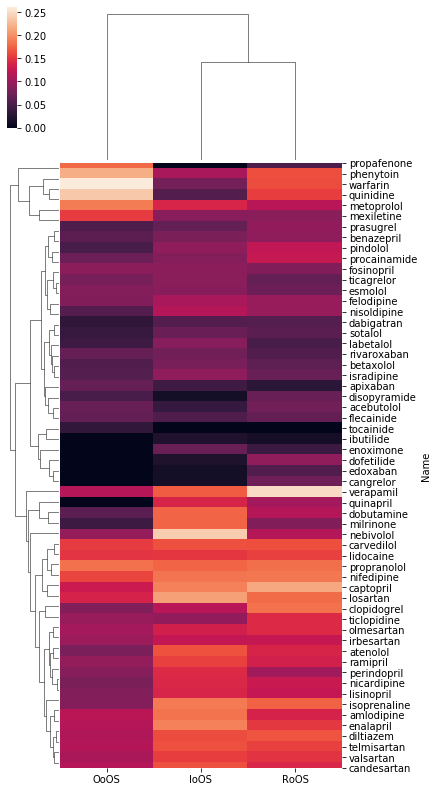

In [13]:
sns.clustermap(drugs_with_caseOLAP[['IoOS', 'OoOS', 'RoOS']], figsize=(6,14));

## Looking for reactions associated with each drug found in the Reactome database

- Looks for 25 "nearest" pathways marked as `Pathways` to any drug within 1-3 nodes
- Outputs to `pathways` variable as a pandas dataframe
- Creates CSV `output/drug_reactome_pathways_caseolap.csv`

In [14]:
# Re-initializing driver to account for changes made to driver function
importlib.reload(neo4j_driver)
driver = neo4j_driver.driver(uri = "bolt://localhost:7687", user = "neo4j", password = "Akre1234")

# For each reactome drug ID, looks for "closest" pathways within 1-2 nodes 
reactions = pd.DataFrame()
for (reactome_id, IoOS, OoOS, RoOS), d_df, in progressbar.progressbar(drugs_with_caseOLAP.groupby(['stId', 'IoOS', 'OoOS', 'RoOS'])):
    query = (
        """
        MATCH (a:Drug {stId: '%s'})-[]-(c)-[]-(b:ReactionLikeEvent)<-[:hasEvent]-(p:Pathway)
        WHERE b.speciesName = 'Homo sapiens'
        AND NOT c.schemaClass IN ['Compartment', 'InstanceEdit']
        RETURN DISTINCT a.displayName, b.displayName, c.displayName, c.schemaClass, p.displayName
        """ % (reactome_id)
    )
    query_res = driver.run_query(query)
    result = driver.results_to_df(query_res, ['a.displayName', 'b.displayName', 'c.displayName', 'c.schemaClass', 'p.displayName'])
    result['IoOS'] = IoOS
    result['OoOS'] = OoOS
    result['RoOS'] = RoOS

    reactions = reactions.append(result, ignore_index=True, sort=False)

reactions = reactions.rename(
    columns={
        'a.displayName': 'Drug',
        'b.displayName': 'Reaction',
        'c.displayName': 'Intermediate Node',
        'c.schemaClass': 'Intermediate Class',
        'p.displayName': 'Pathway'
    }
)
reactions.to_csv('output/drug_reactome_reactions_caseolap.csv', index=False)
reactions.head()


100% (58 of 58) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


,Drug,Reaction,Intermediate Node,Intermediate Class,Pathway,IoOS,OoOS,RoOS
0,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,VKORC1 inhibitors [cytosol],DefinedSet,Metabolism of vitamin K,0.077812,0.261603,0.164026
1,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,Warfarin traps human vitamin K epoxide reducta...,LiteratureReference,Metabolism of vitamin K,0.077812,0.261603,0.164026
2,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,Warfarin and vitamin K compete for binding to ...,LiteratureReference,Metabolism of vitamin K,0.077812,0.261603,0.164026
3,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,Pharmacogenetic-guided dosing of coumarin anti...,LiteratureReference,Metabolism of vitamin K,0.077812,0.261603,0.164026
4,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,"[On the history of vitamin K, dicoumarol and w...",LiteratureReference,Metabolism of vitamin K,0.077812,0.261603,0.164026


In [15]:
reactions = pd.read_csv('output/drug_reactome_reactions_caseolap.csv')
print('Drugs remaining:', reactions.Drug.nunique())
pd.DataFrame(reactions.groupby('Pathway').Drug.nunique()).sort_values(by='Drug', ascending=False)


Drugs remaining: 35


,Drug
Pathway,
Adrenoceptors,11
Metabolism of Angiotensinogen to Angiotensins,8
Peptide ligand-binding receptors,6
Common Pathway of Fibrin Clot Formation,5
Intrinsic Pathway of Fibrin Clot Formation,5
P2Y receptors,5
Defective CYP1B1 causes Glaucoma,1
Metabolism of vitamin K,1


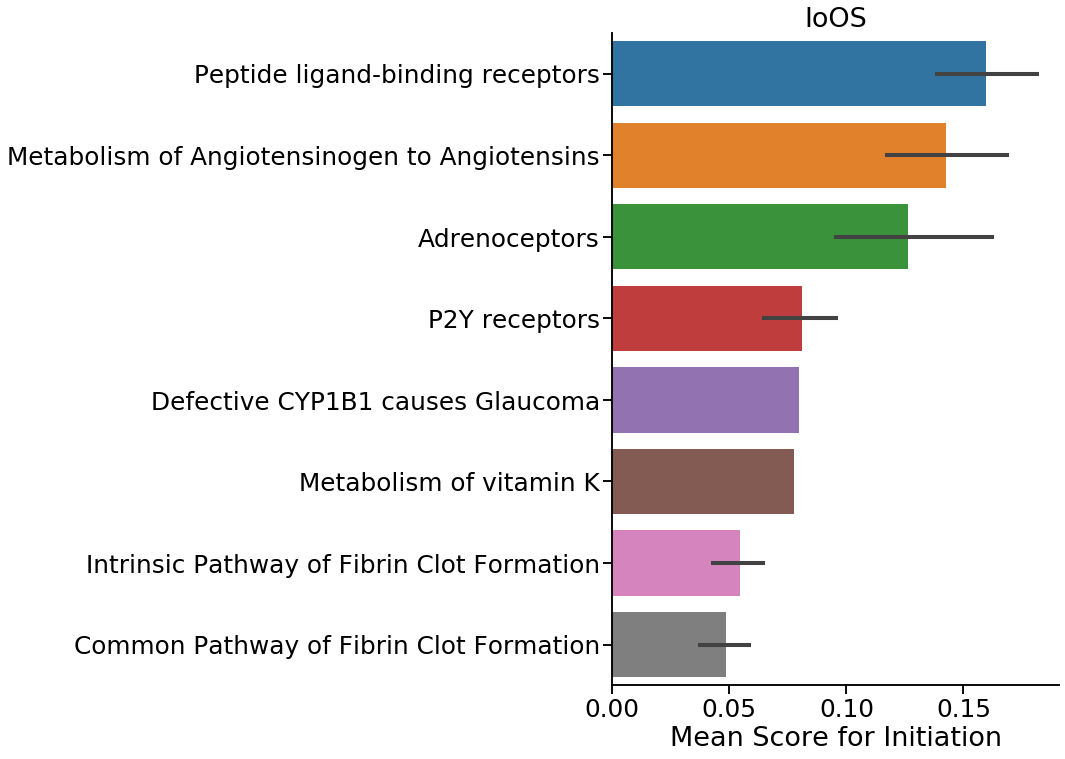

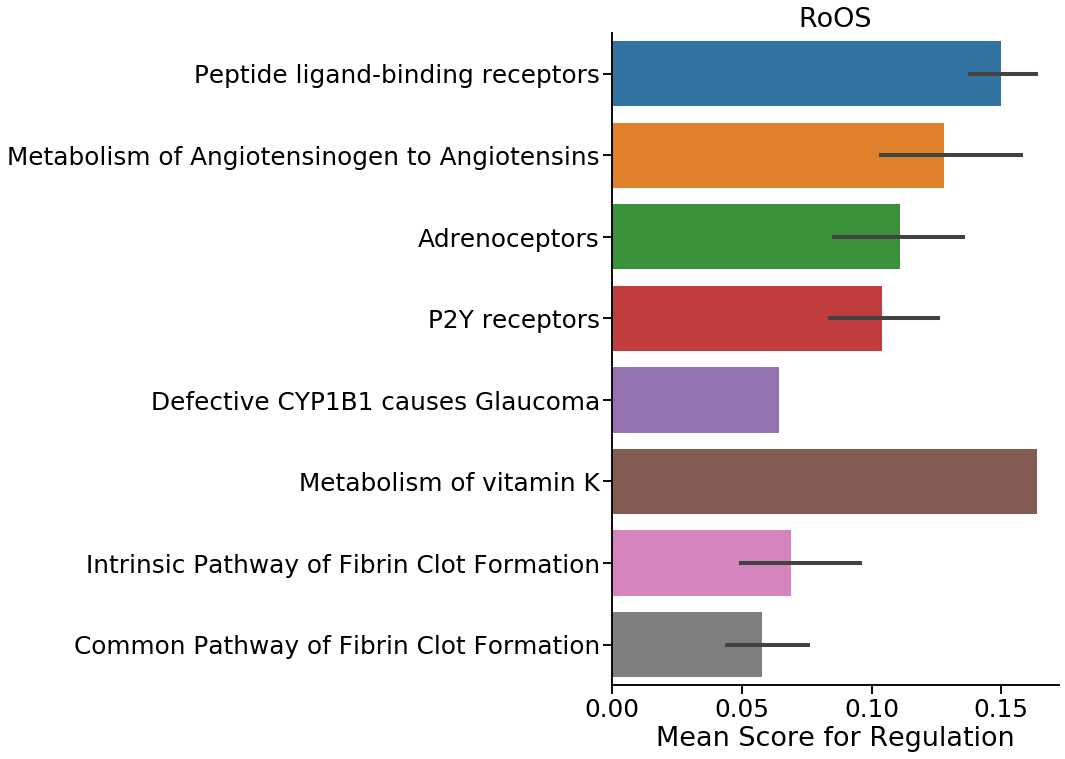

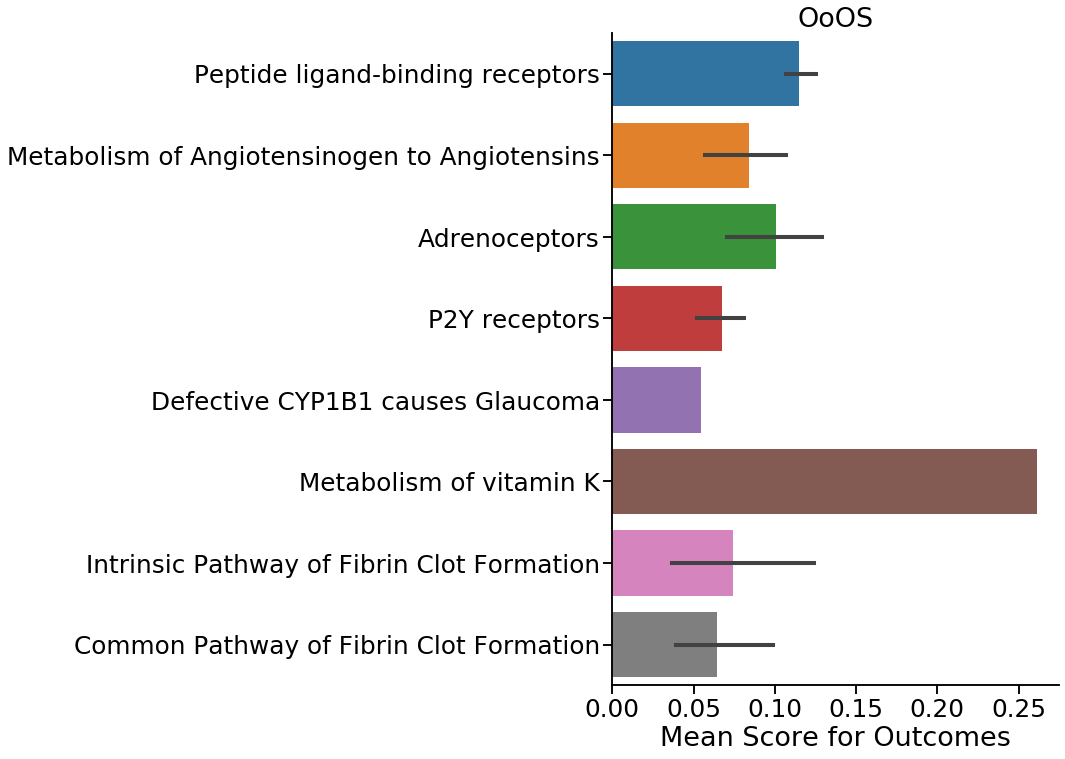

In [28]:



# Pathway by sum score in each category
pathways_IoOS = pd.DataFrame(
    reactions.groupby('Pathway').IoOS.mean()
).reset_index().sort_values(by='IoOS', ascending=False)
pathways_IoOS.head()

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Pathway',
    x='IoOS',
    order=pd.concat([pathways_IoOS.head(15), pathways_IoOS.tail(10)]).drop_duplicates().Pathway,
    data=reactions,
    ax=ax
)
ax.set_xlabel('Mean Score for Initiation')
ax.set_ylabel('')
ax.set_title('IoOS')

sns.despine()


# Pathway by sum score in each category
pathways_RoOS = pd.DataFrame(
    reactions.groupby('Pathway').RoOS.mean()
).reset_index().sort_values(by='RoOS', ascending=False)
pathways_IoOS.head()

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Pathway',
    x='RoOS',
    order=pd.concat([pathways_IoOS.head(15), pathways_IoOS.tail(10)]).drop_duplicates().Pathway,
    data=reactions,
    ax=ax
)
ax.set_xlabel('Mean Score for Regulation')
ax.set_ylabel('')
ax.set_title('RoOS')

sns.despine()

# Pathway by sum score in each category
pathways_OoOS = pd.DataFrame(
    reactions.groupby('Pathway').OoOS.mean()
).reset_index().sort_values(by='OoOS', ascending=False)

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Pathway',
    x='OoOS',
    order=pd.concat([pathways_IoOS.head(15), pathways_IoOS.tail(10)]).drop_duplicates().Pathway,
    data=reactions,
    ax=ax
)
ax.set_xlabel('Mean Score for Outcomes')
ax.set_ylabel('')
ax.set_title('OoOS')

sns.despine()

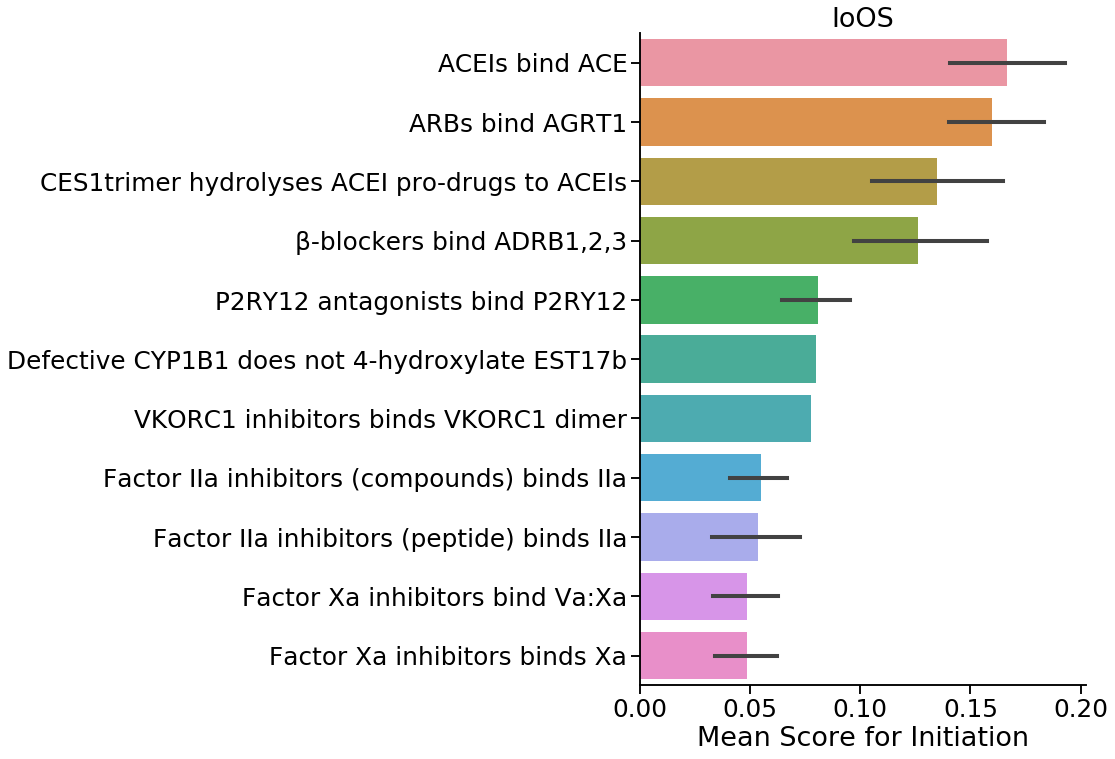

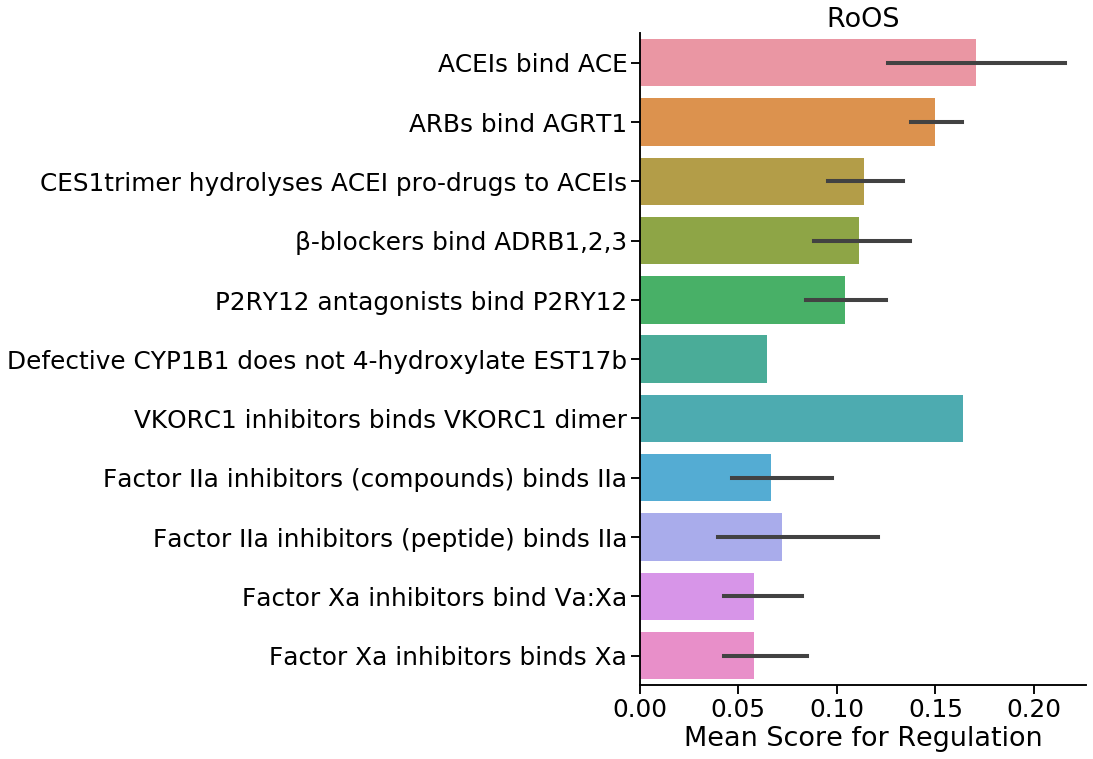

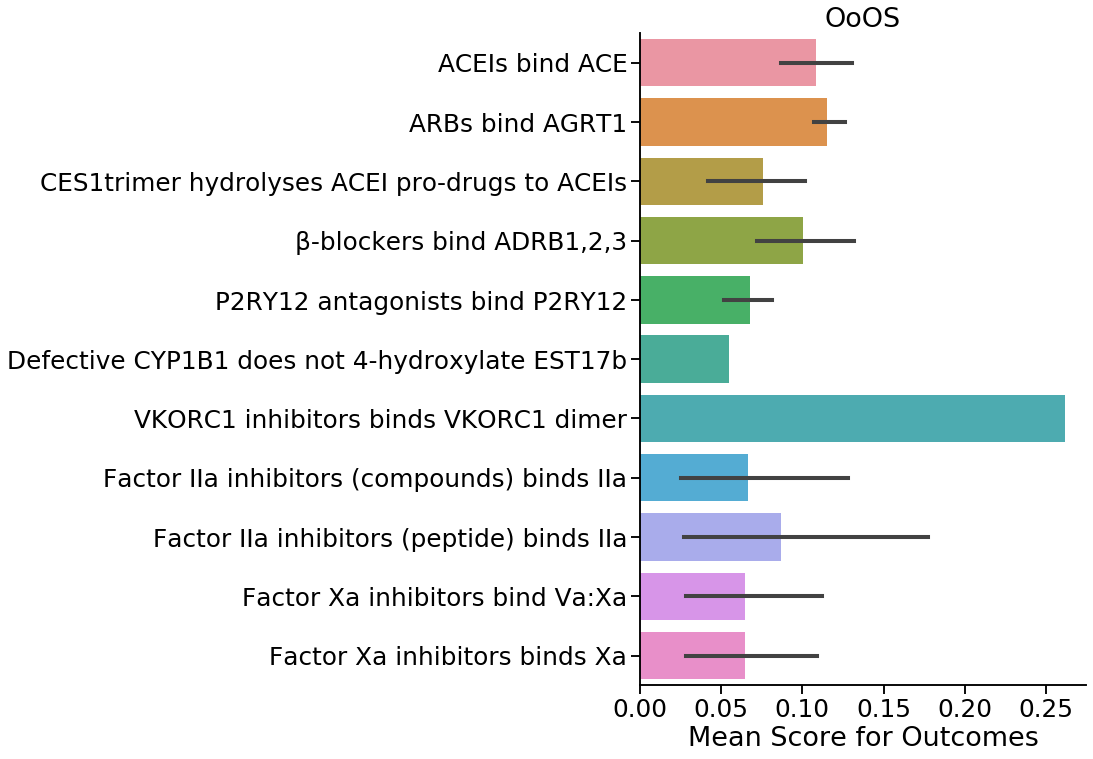

In [29]:



# Pathway by sum score in each category
pathways_IoOS = pd.DataFrame(
    reactions.groupby('Reaction').IoOS.mean()
).reset_index().sort_values(by='IoOS', ascending=False)
pathways_IoOS.head()

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Reaction',
    x='IoOS',
    order=pd.concat([pathways_IoOS.head(15), pathways_IoOS.tail(10)]).drop_duplicates().Reaction,
    data=reactions,
    ax=ax
)
ax.set_xlabel('Mean Score for Initiation')
ax.set_ylabel('')
ax.set_title('IoOS')

sns.despine()


# Pathway by sum score in each category
pathways_RoOS = pd.DataFrame(
    reactions.groupby('Reaction').RoOS.mean()
).reset_index().sort_values(by='RoOS', ascending=False)
pathways_IoOS.head()

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Reaction',
    x='RoOS',
    order=pd.concat([pathways_IoOS.head(15), pathways_IoOS.tail(10)]).drop_duplicates().Reaction,
    data=reactions,
    ax=ax
)
ax.set_xlabel('Mean Score for Regulation')
ax.set_ylabel('')
ax.set_title('RoOS')

sns.despine()

# Pathway by sum score in each category
pathways_OoOS = pd.DataFrame(
    reactions.groupby('Reaction').OoOS.mean()
).reset_index().sort_values(by='OoOS', ascending=False)

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Reaction',
    x='OoOS',
    order=pd.concat([pathways_IoOS.head(15), pathways_IoOS.tail(10)]).drop_duplicates().Reaction,
    data=reactions,
    ax=ax
)
ax.set_xlabel('Mean Score for Outcomes')
ax.set_ylabel('')
ax.set_title('OoOS')

sns.despine()

In [27]:
reactions[reactions.Drug.str.contains('warfarin')]

,Drug,Reaction,Intermediate Node,Intermediate Class,Pathway,IoOS,OoOS,RoOS
0,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,VKORC1 inhibitors [cytosol],DefinedSet,Metabolism of vitamin K,0.077812,0.261603,0.164026
1,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,Warfarin traps human vitamin K epoxide reducta...,LiteratureReference,Metabolism of vitamin K,0.077812,0.261603,0.164026
2,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,Warfarin and vitamin K compete for binding to ...,LiteratureReference,Metabolism of vitamin K,0.077812,0.261603,0.164026
3,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,Pharmacogenetic-guided dosing of coumarin anti...,LiteratureReference,Metabolism of vitamin K,0.077812,0.261603,0.164026
4,warfarin [cytosol],VKORC1 inhibitors binds VKORC1 dimer,"[On the history of vitamin K, dicoumarol and w...",LiteratureReference,Metabolism of vitamin K,0.077812,0.261603,0.164026
5,warfarin [cytosol],Factor Xa inhibitors bind Va:Xa,pulmonary embolism,Disease,Common Pathway of Fibrin Clot Formation,0.077812,0.261603,0.164026
6,warfarin [cytosol],Factor Xa inhibitors binds Xa,pulmonary embolism,Disease,Common Pathway of Fibrin Clot Formation,0.077812,0.261603,0.164026
7,warfarin [cytosol],Factor IIa inhibitors (compounds) binds IIa,pulmonary embolism,Disease,Intrinsic Pathway of Fibrin Clot Formation,0.077812,0.261603,0.164026
8,warfarin [cytosol],Factor IIa inhibitors (peptide) binds IIa,pulmonary embolism,Disease,Intrinsic Pathway of Fibrin Clot Formation,0.077812,0.261603,0.164026


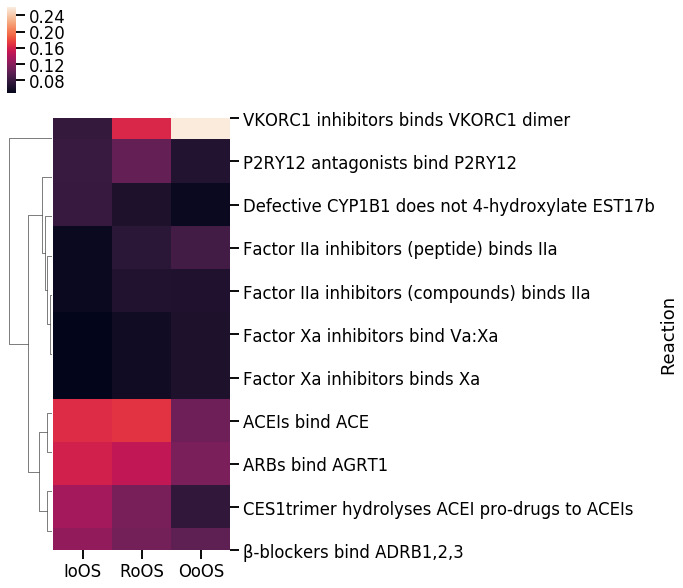

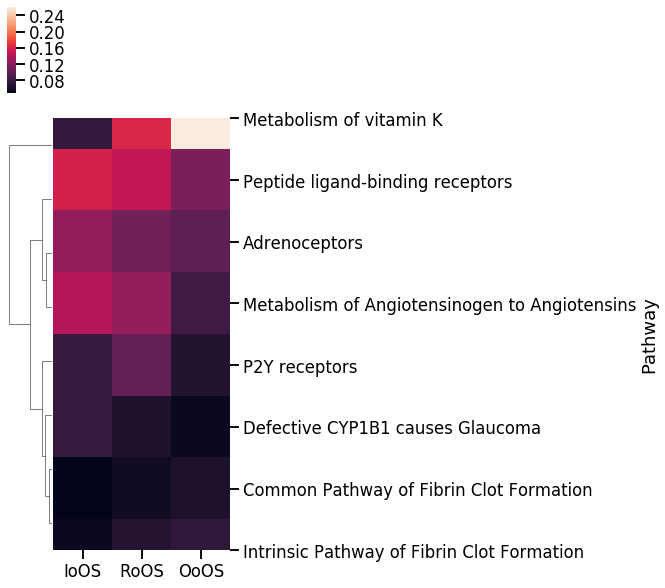

In [26]:
import sys
sys.setrecursionlimit(100000)
sns.set_context('talk', font_scale=1)
sns.clustermap(reactions.groupby('Reaction')[['IoOS', 'RoOS', 'OoOS']].mean(), col_cluster=False, figsize=(4, 10))
sns.clustermap(reactions.groupby('Pathway')[['IoOS', 'RoOS', 'OoOS']].mean(), col_cluster=False, figsize=(4, 10))

## Test Cypher Queries in custom neo4j driver implementation

In [59]:
reactome_driver.get_node_info(
    id_field="stId",
    id_val="R-ALL-9634956",
    class_type='Drug',
    info_cols = ['displayName', 'name', 'isInDisease']
)

Query: 
 MATCH (a:Drug {stId: $idnum}) RETURN a.displayName, a.name, a.isInDisease 
pyridostigmine [extracellular region]
['pyridostigmine']
True


,displayName,name,isInDisease
0,pyridostigmine [extracellular region],[pyridostigmine],True


In [131]:
reactome_driver.get_n_nodes_info(
    class_type='Drug',
    info_cols = ['displayName', 'name', 'isInDisease'],
    n=10
)

Query: 
 MATCH (a:Drug) RETURN a.displayName, a.name, a.isInDisease LIMIT 10


,displayName,name,isInDisease
0,trastuzumab [extracellular region],"[trastuzumab, herceptin, D5v8, R-597]",True
0,CP-724714 [cytosol],[CP-724714],True
0,Afatinib [cytosol],"[Afatinib, BIBW2992, Irreversible TKI inhibito...",True
0,AZ5104 [cytosol],[AZ5104],True
0,Sapitinib [cytosol],[Sapitinib],True
0,Tesevatinib [cytosol],"[Tesevatinib, EXEL-7647, XL-647, KD-019, XL647]",True
0,Lapatinib [cytosol],"[Lapatinib, GW572016, Tykerb, Reversible tyros...",True
0,Neratinib [cytosol],"[Neratinib, HKI-272, afatinib, Irreversible ty...",True
0,AEE788 [cytosol],[AEE788],True
0,Canertinib [cytosol],"[Canertinib, CI-1033, Irreversible TKI inhibit...",True
